In [13]:
import shapely.affinity
from shapely.geometry import Point,mapping, LineString, Polygon
import numpy as np
import rasterio
from rasterio import plot, mask
from rtree import index
import networkx as nx
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from cartopy import crs
import xml.etree.ElementTree as ET
import gpxpy.gpx
from pyproj import CRS
from pyproj import Transformer
from math import atan, degrees

In [14]:
study_area_shapely = Polygon([(275000,77000),(276000,77000),(276000,78000),(275000,78000)])
#study_area_shp = gpd.read_file(os.path.join('Study_area','study_area.shp'))
Haytor_map = rasterio.open(
        os.path.join('OS Explorer Maps', 'Download_SX77-Haytor_2033809', 'raster-25k_4596071', 'sx', 'sx77.tif'))
elevation = rasterio.open(os.path.join('OS Elevation','Download_Haytor_Elevation_2035988','terrain-5-dtm_4600215','sx','SX77NE.asc'))

study_area = mapping(study_area_shapely)
elevation_mask, transform_index = mask.mask(elevation,[study_area], filled=False, crop=False)

network_links = gpd.read_file(os.path.join('Study_area','network_links.geojson'))
network_nodes = gpd.read_file(os.path.join('Study_area','network_nodes.geojson'))

Creating the Network(Grouped)

In [15]:
graph = nx.Graph()
for index, row in network_links.iterrows():
    graph.add_edge(row['startnode'], row['endnode'], fid=row['fid'], weight=row['length'] )

path = nx.dijkstra_path(graph, source=1, target=1241, weight="weight")

geom = []
links = []
first_node = path[0]
for node in path[1:]:
    link_fid = graph.edges[first_node, node]['fid']
    links.append(link_fid)
    row = network_links.loc[network_links['fid'] == link_fid]
    geom.append(row['geometry'].cascaded_union)
    first_node = node

path_gpd = gpd.GeoDataFrame({'fid': links, 'geometry': geom})
path_gpd

,fid,geometry
0,2,"LINESTRING (275000.000 77000.000, 275025.000 7..."
1,205,"LINESTRING (275025.000 77000.000, 275050.000 7..."
2,527,"LINESTRING (275050.000 77000.000, 275075.000 7..."
3,849,"LINESTRING (275075.000 77000.000, 275100.000 7..."
4,1171,"LINESTRING (275100.000 77000.000, 275125.000 7..."
5,1493,"LINESTRING (275125.000 77000.000, 275150.000 7..."
6,1815,"LINESTRING (275150.000 77000.000, 275175.000 7..."
7,2138,"LINESTRING (275175.000 77000.000, 275200.000 7..."
8,2468,"LINESTRING (275200.000 77025.000, 275225.000 7..."
9,2798,"LINESTRING (275225.000 77050.000, 275250.000 7..."


Creating  Dijkstra using 5km/hr walking time

In [16]:
g = nx.DiGraph()
for index,row in network_links.iterrows():
    road_length = row.length

    length_time = road_length / (500 / 6)
    total_time = length_time + row.climb_time_forward

    # applying nazimuths rule of average person walking 5km/hr
    # forward  # applying both the nazimuth rules together

    g.add_edge(row['startnode'], row['endnode'], fid=row['fid'],
               length=road_length,
               time=total_time)

# get the shortest path with time weight
time_weighted_path = nx.dijkstra_path(g, source=1, target=1241, weight='time')

geom = []
links = []
first_node = time_weighted_path[0]
for node in time_weighted_path[1:]:
    link_fid = graph.edges[first_node, node]['fid']
    links.append(link_fid)
    row = network_links.loc[network_links['fid'] == link_fid]
    geom.append(row['geometry'].cascaded_union)
    first_node = node

time_weighted_path_forward_gpd = gpd.GeoDataFrame({'fid': links, 'geometry': geom})
time_weighted_path_forward_gpd

,fid,geometry
0,2,"LINESTRING (275000.000 77000.000, 275025.000 7..."
1,205,"LINESTRING (275025.000 77000.000, 275050.000 7..."
2,527,"LINESTRING (275050.000 77000.000, 275075.000 7..."
3,849,"LINESTRING (275075.000 77000.000, 275100.000 7..."
4,1171,"LINESTRING (275100.000 77000.000, 275125.000 7..."
5,1493,"LINESTRING (275125.000 77000.000, 275150.000 7..."
6,1815,"LINESTRING (275150.000 77000.000, 275175.000 7..."
7,2137,"LINESTRING (275175.000 77000.000, 275200.000 7..."
8,2459,"LINESTRING (275200.000 77000.000, 275225.000 7..."
9,2781,"LINESTRING (275225.000 77000.000, 275250.000 7..."


In [17]:
# get the shortest path with time weight
time_weighted_path = nx.dijkstra_path(g, source=1241, target=2, weight='time')

geom = []
links = []
first_node = time_weighted_path[0]
for node in time_weighted_path[1:]:
    link_fid = graph.edges[first_node, node]['fid']
    links.append(link_fid)
    row = network_links.loc[network_links['fid'] == link_fid]
    geom.append(row['geometry'].cascaded_union)
    first_node = node

time_weighted_path_backward_gpd = gpd.GeoDataFrame({'fid': links, 'geometry': geom})
time_weighted_path_backward_gpd

,fid,geometry
0,9617,"LINESTRING (275750.000 77250.000, 275725.000 7..."
1,9295,"LINESTRING (275725.000 77250.000, 275700.000 7..."
2,8973,"LINESTRING (275700.000 77250.000, 275675.000 7..."
3,8651,"LINESTRING (275675.000 77250.000, 275650.000 7..."
4,8329,"LINESTRING (275650.000 77250.000, 275625.000 7..."
5,8007,"LINESTRING (275625.000 77250.000, 275600.000 7..."
6,7685,"LINESTRING (275600.000 77250.000, 275575.000 7..."
7,7363,"LINESTRING (275575.000 77250.000, 275550.000 7..."
8,7043,"LINESTRING (275550.000 77250.000, 275550.000 7..."
9,7035,"LINESTRING (275550.000 77225.000, 275550.000 7..."


C:\Users\Raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  
C:\Users\Raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:34: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.


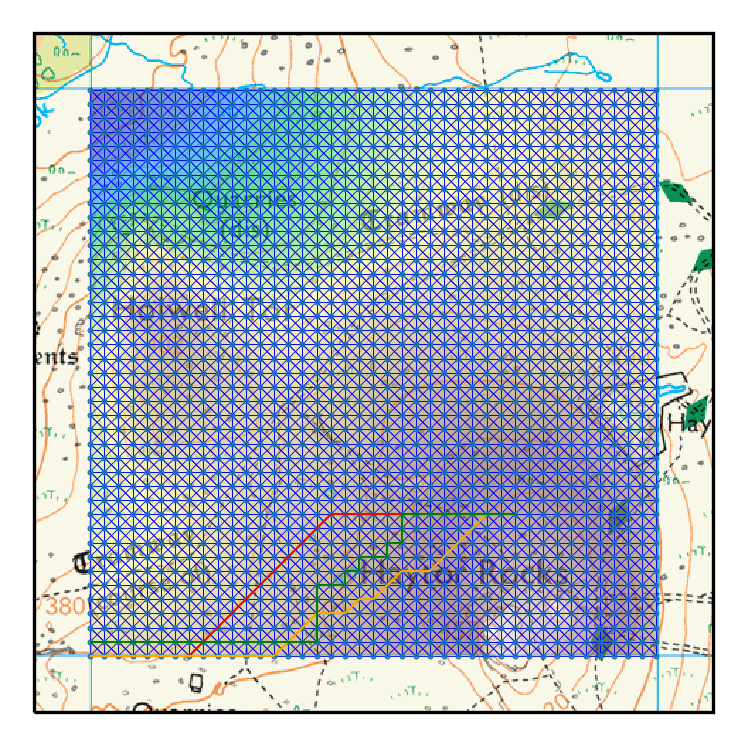

In [18]:
back_array = Haytor_map.read(1)
palette = np.array([value for key, value in Haytor_map.colormap(1).items()])
background_image = palette[back_array]
bounds = Haytor_map.bounds
extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

fig = plt.figure(figsize=(3, 3), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=crs.OSGB())

# display background map
ax.imshow(background_image, origin='upper', extent=extent, zorder=0)

# display elevation
rasterio.plot.show(elevation_mask, alpha=0.6, transform=transform_index, ax=ax, zorder=1,
                           cmap='terrain')

# displaying nodes
network_nodes.plot(ax=ax,zorder = 3,markersize=0.2,aspect = 1)

#displaying links
network_links.plot(ax=ax,zorder = 2,edgecolor='blue', linewidth=0.2,aspect = 1)

# display path
path_gpd.plot(ax=ax,zorder = 4,edgecolor='red', linewidth=0.5,aspect = 1)
time_weighted_path_forward_gpd.plot(ax=ax,zorder = 5,edgecolor='orange', linewidth=0.5,aspect = 1)
time_weighted_path_backward_gpd.plot(ax=ax,zorder = 5,edgecolor='green', linewidth=0.5,aspect = 1)


#set the extent to the study area
#study_area_gpd.plot(ax=ax,zorder = 2)
display_extent = ((study_area_shapely.bounds[0]- 100, study_area_shapely.bounds[2]+ 100,
                       study_area_shapely.bounds[1]- 100, study_area_shapely.bounds[3]+ 100))

ax.set_extent(display_extent, crs=crs.OSGB())
plt.show()

Removing Points wehre